Quick first look at the Chandra spectra, check for variation and phase coverage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [3]:
sp = glob.glob('test_spectra/*fits')
sp

['test_spectra/ob1_test_p1.fits', 'test_spectra/ob2_test_p1.fits']

In [4]:
fits.getdata(sp[0],1).names

['CHANNEL',
 'COUNTS',
 'STAT_ERR',
 'BACKGROUND_UP',
 'BACKGROUND_DOWN',
 'BIN_LO',
 'BIN_HI']

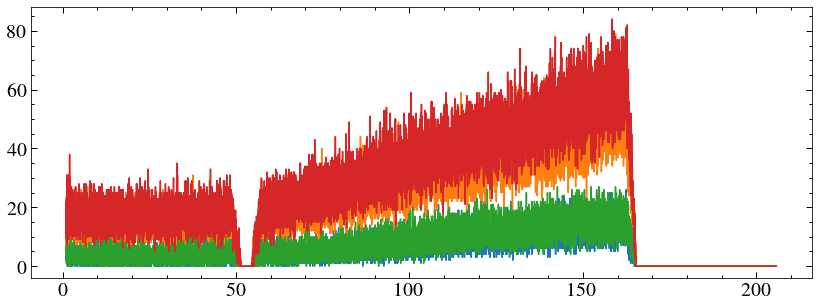

In [9]:
for s in sp:
    data = fits.getdata(s,1)
    plt.plot(data['BIN_LO'],data['COUNTS'])
    plt.plot(data['BIN_LO'],data['BACKGROUND_UP'])
    

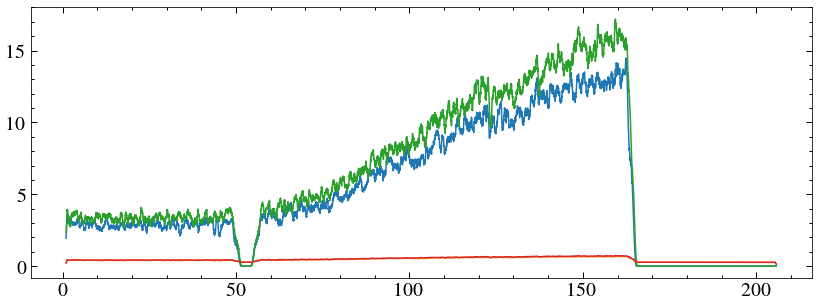

In [8]:
smooth = 50
for s in sp:
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    plt.plot(w, c1)
    plt.plot(w, ce1)

In [15]:
int_counts = []
for s in sp:
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'][::-1], data['COUNTS'], data['STAT_ERR']
    mask = (w > 70) & ( w < 160)
    int_counts.append(np.trapz(c[mask], w[mask]))
print(int_counts)
print(int_counts[0]/int_counts[1])

[579.8937500000204, 677.775000000024]
0.8555844491165946


Timings?

In [68]:
hdul = fits.open(sp[0])
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'PRIMARY '                                                            
ORIGIN  = 'ASC     '           / Source of FITS file                            
CREATOR = 'cxc - Version CIAO 4.12' / tool that created this output             
DS_IDENT= 'ADS/Sa.CXO#obs/21181' / Dataset Identifier: DOI                      
CHECKSUM= 'lojknmgilmgilmgi'   / HDU checksum updated 2020-04-02T22:09:18       
DATASUM = '        '           / data unit checksum updated 2020-03-26T08:56:24 
DATE    = '2020-04-02T22:09:

0.6007639253439265
[0.02570951 0.54957062]
0.7171263456039014
[0.53431853 0.1596467 ]


(0.001, 0.999)

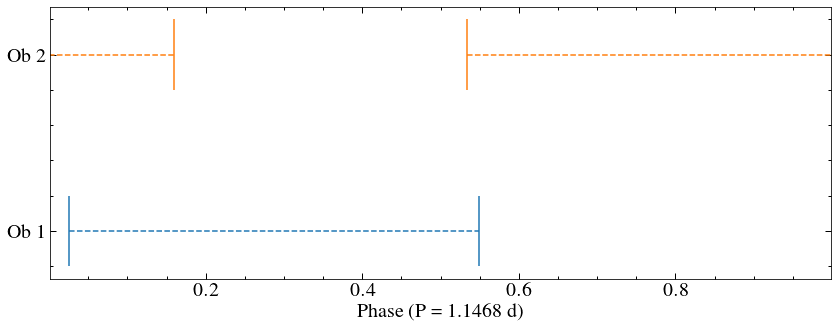

In [81]:
cols= ['C0', 'C1']
plt.figure()
for i ,s in enumerate(sp):
    hdr = fits.getheader(s, 0)
    t = np.array([hdr['TSTART']/86400, hdr['TSTOP']/86400])
    t += hdr['MJDREF']
    print(t[1]-t[0])
    #if i == 0:
     #   tmin = t[0]
    #t = t - tmin
    #plt.errorbar(t, [i,i],  yerr=0.1)
    #plt.show()
    period = 1.1468 #d
    tep = (2458737.560-2400000.5)
    t -=tep  
    tfold = (t/ period) % 1
    #tfold = tfold[np.argsort(tfold)]
    print(tfold)
    #if i == 1:
     #   tfold = tfold-4
    plt.errorbar(tfold, [0.5*i,0.5*i],  yerr=0.1, ls='none', c=cols[i])
    if i == 0:
        plt.plot(tfold, [0.5*i,0.5*i], ls='--', c=cols[i])
    else:
        plt.plot([0, min(tfold)], [0.5*i,0.5*i], ls='--', c=cols[i])
        plt.plot([max(tfold), 1], [0.5*i,0.5*i], ls='--', c=cols[i])
plt.yticks([0, 0.5],['Ob 1', 'Ob 2'])
plt.xlabel('Phase (P = {} d)'.format(period))
plt.xlim(0.001, 0.999)

Yes! Good work Chandra team!

In [101]:
(51906.00314998627+61959.71625995636)/(86400*1.146)

1.1499915104261869

Compare new spectra with the old EUVE spectrum

In [45]:
wv,fv,ev=np.loadtxt('../../spectra/euve/GD394_euve_added.dat', unpack=True) #load data

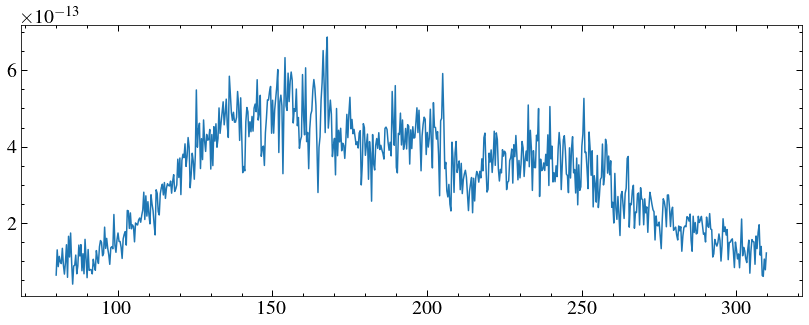

In [48]:
mask=(wv>80.)&(wv<310.) #mask out bad areas
wv,fv,ev=wv[mask], fv[mask], ev[mask] 
plt.plot(wv, fv)

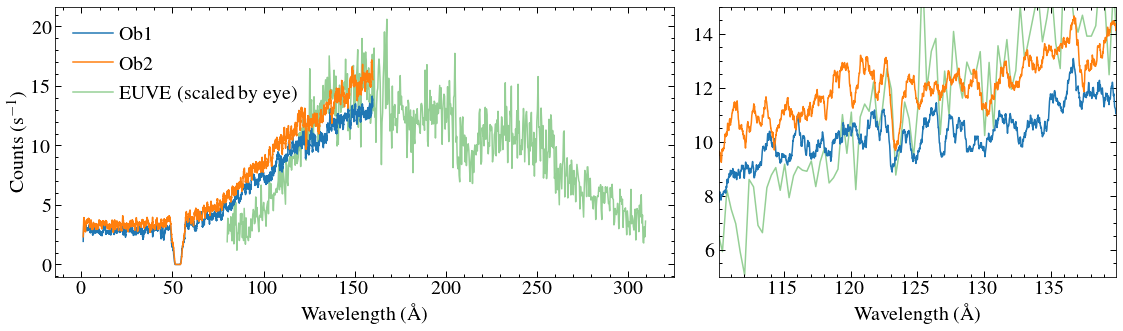

In [100]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 5, figure=fig)
plt.subplot(gs[0,:3])
for i, s in enumerate(sp):
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    mask = w < 160 
    plt.plot(w[mask], c1[mask], label = 'Ob{}'.format(i+1))
    #plt.plot(w, ce1)
plt.plot(wv, fv*3e13, zorder=-1, alpha=0.5, label='EUVE (scaled by eye)')
#plt.xscale('log')
#plt.xlim(10, 400)
plt.legend(loc=2)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Counts (s$^{-1}$)')

plt.subplot(gs[0,-2:])
for i, s in enumerate(sp):
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    mask = w < 160 
    plt.plot(w[mask], c1[mask], label = 'Ob{}'.format(i+1))
    #plt.plot(w, ce1)
plt.plot(wv, fv*3e13, zorder=-1, alpha=0.5, label='EUVE (scaled by eye)')
plt.xlim(110.1, 139.9)
plt.ylim(5, 15)
#plt.xscale('log')
#plt.xlim(10, 400)
#plt.legend()
plt.xlabel('Wavelength (\AA)')
#plt.ylabel('Counts (s$^{-1}$)')

plt.tight_layout()
#plt.savefig('spectra_ql_1.pdf')


In [82]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   28 / width of table in bytes                        
NAXIS2  =                16384 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    7 / number of fields in each row                   
EXTNAME = 'SPECTRUM'           / name of this binary table extension            
HDUNAME = 'SPECTRUM'           / ASCDM block name                               
ORIGIN  = 'ASC     '           / Source of FITS file                            
CREATOR = 'tgextract - Version DS10.8' / tool that created this output          
ASCDSVER= 'CIAO 4.12'       